***
# Associations between kids' screen time and their mental health

Minh-Khang Vu, March 2019.

## Question

Recently, I came across the article [There’s Worrying New Research About Kids’ Screen Time and Their Mental Health](http://time.com/5437607/smartphones-teens-mental-health/). In the article, the author of the study found "a clear and strong association" between more screen time and lower wellbeing. She expressed a concern that digital technology might have a negative effect on health and wellbeing of children. However, there might not be a direct correlation between kids' screen time and mental health as other researchers argued that anxious and depressed kids tend to spend more time using screens. Whether screen time affects children's wellbeing is questionable, but this study still provides an important insight into children's health and wellbeing.

Reading the article, I couldn't find many useful statistics to support the relationship between screen time and children's mental health. Therefore, I'd like to explore whether this relationship exists and present the results with clear visualizations. In this notebook, I used the Census Bureau’s 2017 [National Survey of Children’s Health (NSCH)](https://www.census.gov/data/datasets/2017/demo/nsch/nsch2017.html) to answer the question: how does children's screen time relate to their mental health? Besides the main question, I also experimented with other variables and found out that how often a family has meals together is also associated with their kids' screen time and mental health.

#### About NSCH 2017 Data
The data in this Notebook is from the National Survey of Children's Health (NSCH) in 2017. The NSCH collects data on the physical and emotional health of American children from 0 to 17 years old. The data provides the screen time usage level of children under 18 as well as the anxiety level, `anxiety_lvl`, and depression level, `depression_lvl`, all of which were answered by their parents. Two variables related to screen time usage are time spent on computers and TV daily (`cmputr_time` & `tv_time`), and I will leave these variables as they are instead of combining them because the use of computers and TV may vary across different age groups. In this project, I will also use the variable `family_meals` which indicates how often their family has meals together.

I processed and cleaned the data using this notebook: https://github.com/minhkhang1795/ThinkStats2/blob/master/project1/data/datacleaning.ipynb. Please refer to the notebook to learn more about its Guidelines for Data Use.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from utils import decorate
from thinkstats2 import Pmf, Cdf

import thinkstats2
import thinkplot

from project1_utils import * # My utility

In [2]:
df = pd.read_pickle('data/nsch_2017_topical_clean.pkl')
df.head()

,sc_age_years,cmputr_time,tv_time,anxiety_lvl,depression_lvl,need_treatment,family_meals,homework_unfinished
0,0,0.0,0.0,0.0,0.0,3.0,1.0,NaN
1,13,3.0,2.0,0.0,0.0,3.0,2.0,1.0
2,15,3.0,1.0,0.0,0.0,3.0,2.0,2.0
3,9,4.0,4.0,0.0,0.0,3.0,1.0,1.0
4,8,1.0,2.0,0.0,0.0,3.0,2.0,1.0


***
***
## Methodology & Results

First, I'll plot the screen time (from now on, screen time will refer to both the computer and TV times) versus the percentage of kids with anxiety and with depression in order to see if there are any relationships among them. In these plots, I'll also add a shaded region to illustrate 90% Confidence Interval of the percentages.

### 1. Screen time vs Anxiety/Depression levels
Variables used: `cmputr_time`, `tv_time`, `anxiety_lvl`, `depression_lvl`

To make this plot, I'll categorize the data into bins of screen time level, from 0 (None) to 5 (>4 hrs daily). In each bins, I calculate the percentage of kids having anxiety or depression problems recently. In the `anxiety_lvl` and `depression_lvl` data series, **zeros** indicates that the kid does not have that condition recently, while **positive values** indicate the severity of the condition. For now, we just want to know whether or not the kid has any anxiety/depression problems.

As an example, I'll start with `cmputr_time` versus `anxiety_lvl`:

In [3]:
# Categorize data into bins
dataSeries = df['cmputr_time']
bins = np.arange(dataSeries.min(), dataSeries.max() + 1, 1)
indices = np.digitize(dataSeries, bins)
groups = df.groupby(indices)
print("Bins", bins)

Bins [0. 1. 2. 3. 4. 5.]


In [4]:
# For each bin, calculate the percentage of kids having anxiety
perc = [] # Percentage list
for i, group in groups:
    total = group['anxiety_lvl'].count()
    positives = group['anxiety_lvl'][group['anxiety_lvl'] > 0].count() # Having anxiety
    perc.append(positives/total * 100)
print("Corresponding percentages", perc)

Corresponding percentages [2.5418474891506513, 5.117168818747011, 7.533946561541831, 8.913890090869753, 12.620912022109627, 15.96607669616519]


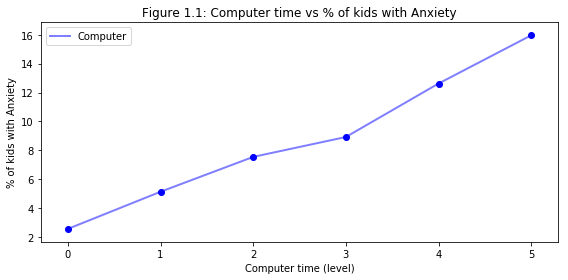

In [5]:
# Plot Computer time vs % of kids with Anxiety
fig, ax = plt.subplots(figsize=(8,4))
ax.plot(bins, perc, label='Computer', linewidth=2, color='blue', alpha=0.5)
ax.scatter(bins, perc, linewidth=1, color='blue', alpha=1)
decorate(title='Figure 1.1: Computer time vs % of kids with Anxiety', xlabel='Computer time (level)', ylabel='% of kids with Anxiety')

As we can see in Figure 1.1, Computer time (level) and % of kids with Anxiety has a linear relationship. In this figure, we can see that about 16% of kids spending 4 hours or more with computers have some anxiety problems.

Next, I will find the 90% CI of the line above.

In [6]:
# Take a sample from the data (with replacement) 
# and run many iterations to find estimates at each percentage points.
t = [] # List of estimates
for _ in range(101):
    sample = thinkstats2.ResampleRows(df)
    # This function groups the DataFrame into bins of cmputr_time
    bins, groups = GroupToBins(sample, 'cmputr_time', bin_size=1)
    # For each binned group, calculate the percentage of kids having anxiety
    estimates = []
    for i, group in groups:
        total = group['anxiety_lvl'].count()
        positives = group['anxiety_lvl'][group['anxiety_lvl'] > 0].count() # Having anxiety
        estimates.append(positives/total * 100)
    
    t.append(estimates)

# Now for each list of estimates, find the 90% CI
estimatesList = np.array(t).transpose()
cis = []
for estimates in estimatesList:
    cis.append(ComputeCI(estimates))
cis = np.array(cis).transpose()

Now, re-plot the results with 90% CI. The 90% CI of the rightmost tail (for kids spending > 4hrs) seems to have a wider range, meaning that this estimate has higher uncertainty.

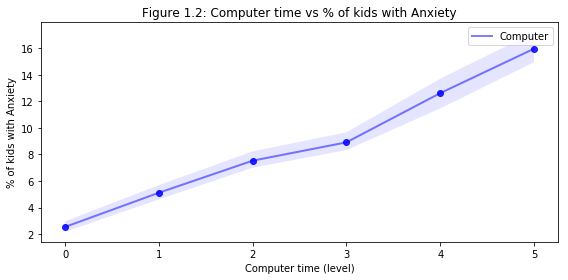

In [7]:
# Plot Computer time vs % of kids with Anxiety with 90% CI
fig, ax = plt.subplots(figsize=(8,4))
plotLineWithCI(ax, bins, perc, cis, label='Computer', color='blue')
decorate(title='Figure 1.2: Computer time vs % of kids with Anxiety', 
         xlabel='Computer time (level)', ylabel='% of kids with Anxiety')

I'll wrap up everything into functions and put them in the `project_utils.py` library. The codeblock below plots the depression and anxiety levels versus screen time. 

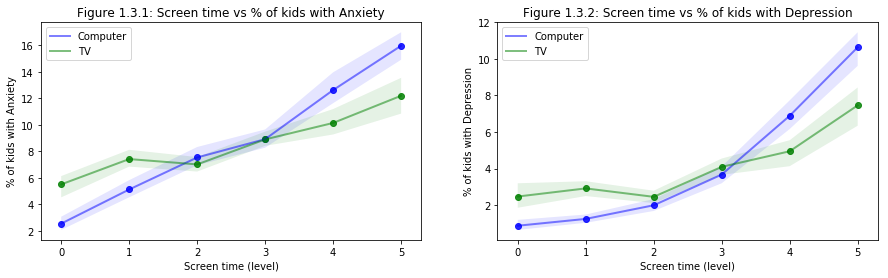

In [8]:
variables = ['anxiety_lvl', 'depression_lvl']
labels = ['Anxiety', 'Depression']
fig, ax = plt.subplots(1, 2, figsize=(15,4))

for i in range(len(labels)):
    bins, perc = CalculatePercentages(GroupToBins(df, group_name='cmputr_time'), variable=variables[i])
    bins_tv, perc_tv = CalculatePercentages(GroupToBins(df, group_name='tv_time'), variable=variables[i])
    cis = ComputeCIs(SamplingDistributions(df, group_name='cmputr_time', Operation=CalculatePercentages, variable=variables[i]))
    cis_tv = ComputeCIs(SamplingDistributions(df, group_name='tv_time', Operation=CalculatePercentages, variable=variables[i]))
    # Computer time
    plotLineWithCI(ax[i], bins, perc, cis, label='Computer', color='blue')

    # TV time
    plotLineWithCI(ax[i], bins_tv, perc_tv, cis_tv, label='TV', color='green')

    ax[i].legend(loc='best')
    ax[i].title.set_text("Figure 1.3." + str(i + 1) +": Screen time vs % of kids with " + labels[i])
    ax[i].set(xlabel='Screen time (level)', ylabel='% of kids with ' + labels[i])

In [9]:
fig.savefig("screen-time-vs-percentages", quality=100, dpi=200)

In general, screen time has a strong linear relationship with anxiety and depression levels. The computer usage line has a steeper slope than the TV usage line, which indicates that computer usage might have a stronger relationship with anxiety/depression levels than the TV usage.

For kids using computers more than 4 hours per day (level 5 in the plots), about 16% of them have some anxiety problems and 11% of them experience depression recently.

In [10]:
# % of kids in level 5 computer time have Anxiety
_, perc = CalculatePercentages(GroupToBins(df, group_name='cmputr_time'), variable='anxiety_lvl')
cis = ComputeCIs(SamplingDistributions(df, group_name='cmputr_time', Operation=CalculatePercentages, variable='anxiety_lvl'))
print("Effect size: " + str(perc[5]) + " %") 
print("CI ", cis[0][5], cis[1][5])

Effect size: 15.96607669616519 %
CI  14.816190122539918 17.264325323475045


In [11]:
# % of kids in level 5 computer time have Depression
_, perc = CalculatePercentages(GroupToBins(df, group_name='cmputr_time'), variable='depression_lvl')
cis = ComputeCIs(SamplingDistributions(df, group_name='cmputr_time', Operation=CalculatePercentages, variable='depression_lvl'))
print("Effect size: " + str(perc[5]) + " %") 
print("CI ", cis[0][5], cis[1][5])

Effect size: 10.636731689363268 %
CI  9.71407624633431 11.769005847953217


#### High screen vs low screen usage

Looking at the plots above, we can see the strong linear relationship between screen time and the likelihood of enduring anxiety and depression. However, it's still hard to quantify the effect size across the screen time level. In this section, I'd like to find out the proportion of kids having mental problems in the high screen time usage to those in the low screen time usage. First, let's define the low and high screen time usage as follows:
- Low screen time usage: spending on computers less than 3 hours a day (level 0 - 2)
- High screen time usage: spending on computers equal or more than 3 hours (level 3 - 5)

The process is nearly the same as what I just did above. However, instead of grouping the data into bins of size 1 (the range of level of each bin is 1), I will group them into bins of size 3. 

Below are the results for kids having depression:

In [12]:
groupResults = GroupToBins(df, group_name='cmputr_time', bin_size=3)
perc, proportionalPerc = CalculateProportionalPercentage(groupResults, variable='depression_lvl')
print("Low screen time usage: " + str(round(perc[0], 2)) + "% having depression.")
print("High screen time usage: " + str(round(perc[1], 2)) + "% having depression.")
print("Proportion of percentages of kids having depression (high/low):", round(proportionalPerc, 2))

Low screen time usage: 1.43% having depression.
High screen time usage: 6.39% having depression.
Proportion of percentages of kids having depression (high/low): 4.48


The 4.48 value indicates that children who spend 3 hours or more daily using computers are _four_ times more likely to experience depression. Below is the 90% CI for this estimate:

In [13]:
estimates = SamplingDistributions(df, group_name='cmputr_time', Operation=CalculateProportionalPercentage, 
                                  bin_size=3, variable='depression_lvl')
ci = ComputeCI(estimates)
ci

(3.8580845704485776, 5.241064052736919)

 I did the similar analysis with the Anxiety Level and found out that children are _twice_ more likely to have an anxiety problem if they spend too much time using computers.

In [14]:
groupResults = GroupToBins(df, group_name='cmputr_time', bin_size=3)
perc, proportionalPerc = CalculateProportionalPercentage(groupResults, variable='anxiety_lvl')
print("Low screen time usage: " + str(round(perc[0], 2)) + "% having anxiety.")
print("High screen time usage: " + str(round(perc[1], 2)) + "% having anxiety.")
print("Proportion of percentages of kids having depression (high/low):", round(proportionalPerc, 2))

Low screen time usage: 5.34% having anxiety.
High screen time usage: 11.77% having anxiety.
Proportion of percentages of kids having depression (high/low): 2.2


In [15]:
estimates = SamplingDistributions(df, group_name='cmputr_time', Operation=CalculateProportionalPercentage, 
                                  bin_size=3, variable='anxiety_lvl')
ci = ComputeCI(estimates)
ci

(2.040280007122912, 2.344358635299402)

#### p-values of the effects

Next, let's see if these effects (four/two times more likely to experience depression/anxiety) are due to chance. I'll calculate the p-values assuming that time spent on computers does not have any effect on the depression/anxiety levels.

Below is the Hypothesis Test.

In [16]:
class ProportionalTest():
    def __init__(self, data, group_name='cmputr_time', variable='depression_lvl'):
        self.data = df.dropna(subset=[group_name, variable])
        self.group_name = group_name
        self.variable = variable
        self.actual = self.TestStatistic(data)
        
    def PValue(self, iters=1000):
        self.test_stats = [self.TestStatistic(self.RunModel()) for _ in range(iters)]
        count = sum(1 for x in self.test_stats if x >= self.actual)
        return 100 * count / iters
        
    def TestStatistic(self, data):
        # Calculate Proportional Percentage
        groupResults = GroupToBins(data, self.group_name, bin_size=3)
        _, perc = CalculatePercentages(groupResults, self.variable)
        return perc[1]/perc[0]

    def RunModel(self):
        # Copy the data frame
        shuffled_data = self.data.copy()
        # Permutate the rows of the depression_lvl column on the copy
        shuffled_column = np.random.permutation(shuffled_data[self.variable]) 
        shuffled_data[self.variable] = shuffled_column
        return shuffled_data

The results are zeros for both effects, which means that the effects are statistically significant.

In [17]:
# p-value of the effect: four times more likely to experience depression
p_test = ProportionalTest(df, group_name='cmputr_time', variable='depression_lvl')
p_test.PValue()

0.0

In [18]:
# p-value of the effect: two times more likely to experience anxiety
p_test = ProportionalTest(df, group_name='cmputr_time', variable='anxiety_lvl')
p_test.PValue()

0.0

### 2. Gauging the anxiety/depression levels

So far, we have not taken into account the anxiety/depression severity level. In this section, I want to see if a child is having anxiety or depression, how bad it could be? 

I'll plot the screen time versus the severity. The method is nearly the same as above. The only difference is that we only look at children the who have anxiety/depression and we will take the mean score of the anxiety/depression level. According to the codebook, the scores are as follows:
- 1 = Mild
- 2 = Moderate
- 3 = Severe

In [19]:
# Operation on each group: calculate mean score of anxiety/depression severity level
def CalculateMeans(groupResults, variable='depression_lvl'):
    bins, groups = groupResults
    means = [] # Mean score of anxiety/depression level
    for i, group in groups:
        positives = group[variable][group[variable] > 0] # Only consider kids having anxiety/depression
        means.append(positives.mean())
    return np.array(bins), np.array(means)

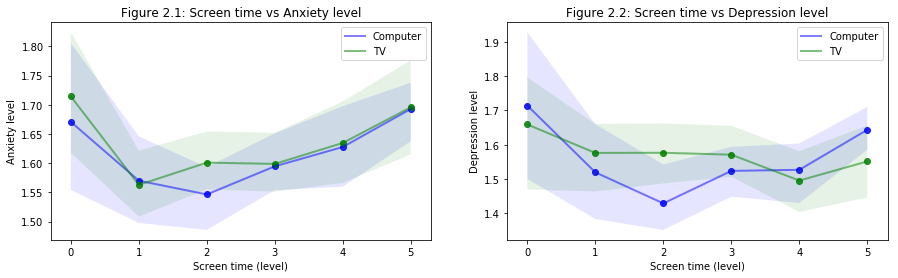

In [20]:
variables = ['anxiety_lvl', 'depression_lvl']
labels = ['Anxiety level', 'Depression level']
fig, ax = plt.subplots(1, 2, figsize=(15,4))

for i in range(len(labels)):
    bins, perc = CalculateMeans(GroupToBins(df, group_name='cmputr_time'), variable=variables[i])
    bins_tv, perc_tv = CalculateMeans(GroupToBins(df, group_name='tv_time'), variable=variables[i])
    cis = ComputeCIs(SamplingDistributions(df, group_name='cmputr_time', Operation=CalculateMeans, variable=variables[i]))
    cis_tv = ComputeCIs(SamplingDistributions(df, group_name='tv_time', Operation=CalculateMeans, variable=variables[i]))
    # Computer time
    plotLineWithCI(ax[i], bins, perc, cis, label='Computer', color='blue')

    # TV time
    plotLineWithCI(ax[i], bins_tv, perc_tv, cis_tv, label='TV', color='green')

    ax[i].legend(loc='best')
    ax[i].title.set_text("Figure 2." + str(i + 1) +": Screen time vs " + labels[i])
    ax[i].set(xlabel='Screen time (level)', ylabel=labels[i])

In [21]:
fig.savefig("screen-time-vs-severity", quality=100, dpi=200)

At first, I didn't expect these plots to behave like that. It seems like there is no apparent relationship between screen time and anxiety/depression levels. Surprisingly, kids having zero screen time even have severer anxiety/depression! There is a seemingly linear relationship on the left plot from screen time level 1 to 5, but the lines on the right plot are hard to tell whether there is a relationship between screen time and depression level.

However, when looking closely at the data, I realized that we don't have enough data points to determine whether there is a relationship. The 90% CI gap is too big, which suggests that there is high uncertainty in these graphs.

One thing we could say when looking at the plots is that, in general, the severity is between mild and moderate. However, this conclusion is not very useful and may be misleading, because it suggests that screen time has something to do with anxiety/depression levels. Therefore, it's better not to conclude anything at all.

In [22]:
# Summary of Anxiety level data in each bin
df[df['anxiety_lvl'] > 0].groupby('cmputr_time')['anxiety_lvl'].describe()

,count,mean,std,min,25%,50%,75%,max
cmputr_time,,,,,,,,
0.0,82.0,1.670732,0.703692,1.0,1.0,2.0,2.0,3.0
1.0,214.0,1.570093,0.629660,1.0,1.0,1.0,2.0,3.0
2.0,344.0,1.546512,0.646263,1.0,1.0,1.0,2.0,3.0
3.0,412.0,1.594660,0.645607,1.0,1.0,2.0,2.0,3.0
4.0,274.0,1.627737,0.634852,1.0,1.0,2.0,2.0,3.0
5.0,422.0,1.701422,0.675986,1.0,1.0,2.0,2.0,3.0


In [23]:
# Summary of Depression level data in each bin
df[df['depression_lvl'] > 0].groupby('cmputr_time')['depression_lvl'].describe()

,count,mean,std,min,25%,50%,75%,max
cmputr_time,,,,,,,,
0.0,28.0,1.714286,0.712697,1.0,1.0,2.0,2.0,3.0
1.0,52.0,1.519231,0.699871,1.0,1.0,1.0,2.0,3.0
2.0,91.0,1.428571,0.598941,1.0,1.0,1.0,2.0,3.0
3.0,170.0,1.523529,0.607672,1.0,1.0,1.0,2.0,3.0
4.0,150.0,1.526667,0.631358,1.0,1.0,1.0,2.0,3.0
5.0,281.0,1.658363,0.674015,1.0,1.0,2.0,2.0,3.0


***
### 3. Family meals
Variables used: `family_meals`, `anxiety_lvl`, `depression_lvl`, `cmputr_time`

Along with the relationships between screen time and diagnoses of anxiety and depression, I also found out that how often their family has meals together also affects the children's mental health. In this section, I added one more variable `family_meals` and visualize the relationships between:
- Family meals vs percentage of kids with anxiety
- Family meals vs percentage of kids with depression
- Family meals vs mean computer time (level)

Now, the bins are the frequencies of family meal **during the past week**, and were coded as follows:
- 0 = 0 days
- 1 = 1-3 days
- 2 = 4-6 days
- 3 = Every day

In [24]:
# Bins are the same for all
bins, perc_anxiety = CalculatePercentages(GroupToBins(df, group_name='family_meals'), variable='anxiety_lvl')
_, perc_depression = CalculatePercentages(GroupToBins(df, group_name='family_meals'), variable='depression_lvl')
_, screen_time = CalculateMeans(GroupToBins(df, group_name='family_meals'), variable='cmputr_time')

# Compute 90% CIs for each of them
cis_anxiety = ComputeCIs(SamplingDistributions(df, group_name='family_meals', Operation=CalculatePercentages, variable='anxiety_lvl'))
cis_depression = ComputeCIs(SamplingDistributions(df, group_name='family_meals', Operation=CalculatePercentages, variable='depression_lvl'))
cis_screen_time = ComputeCIs(SamplingDistributions(df, group_name='family_meals', Operation=CalculateMeans, variable='cmputr_time'))

Because the mean computer usage level has a slightly different range compared to the percentages, to visualize these variables on the same plot, I use a two-scale plot: family meal frequency level is on the horizontal axis; the left vertical axis corresponds to percentages having anxiety/depression while the right vertical axis is for the screen time level.

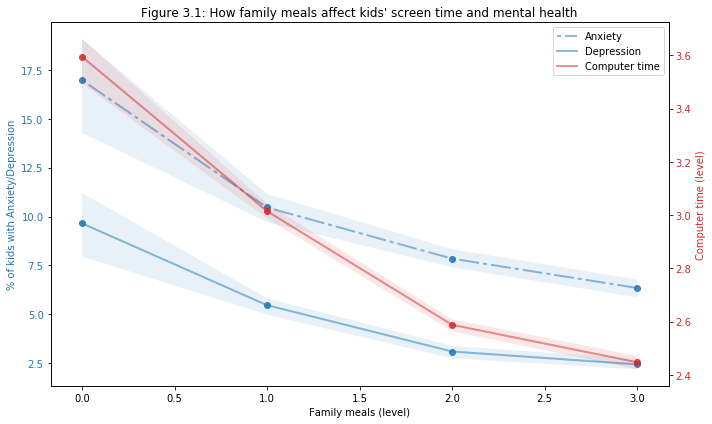

In [25]:
fig, ax2 = plt.subplots(figsize=(10,6))

color = 'tab:blue'
ax2.set_xlabel('Family meals (level)')
ax2.set_ylabel('% of kids with Anxiety/Depression', color=color)

# Anxiety plot
line1 = plotLineWithCI(ax2, bins, perc_anxiety, cis_anxiety, label='Anxiety', color=color)
line1[0].set_dashes([2, 2, 10, 2])

# Depression plot
line2 = plotLineWithCI(ax2, bins, perc_depression, cis_depression, label='Depression', color=color)

ax2.tick_params(axis='y', labelcolor=color)
ax1 = ax2.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:red'
ax1.set_ylabel('Computer time (level)', color=color) # we already handled the x-label with ax2

# Computer time plot
line3 = plotLineWithCI(ax1, bins, screen_time, cis_screen_time, label='Computer time', color=color)

ax1.tick_params(axis='y', labelcolor=color)
ax1.title.set_text('Figure 3.1: How family meals affect kids\' screen time and mental health')

lines = line1 + line2 + line3
labels = [l.get_label() for l in lines]
ax2.legend(lines, labels)
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [26]:
fig.savefig("family-meals", quality=100, dpi=200)

Interestingly, this graph suggests the strong linear relationships between family meals and the likelihood to experience anxiety/depression as well as between family meals and computer time usage. Kids in families having more meals together are less likely to have anxiety/depression, and they also tend to use computers less. It's also worth noting that more than 16% of kids having no meals with their families during the past week experience anxiety problems, while only 8% of kids having meals every day with their families have anxiety. However, we should also be cautious about this result, because the Confidence Intervals on the left tails of the 3 lines are much wider than the CIs on the other end.

## Interpretation

This notebook has shown some interesting results from the NSCH 2017:
- For kids spending 4 hours or more with computers, about 16% of them have some anxiety problems (CI 14.98 17.07), and 11% of them experience depression recently (CI 9.73 11.61).
- Second, Children who spend 3 hours or more daily using computers are twice more likely to have an anxiety problem (CI 2.06 2.38) and four times more likely to experience depression (CI 3.97 5.11) than those who spend less than 3 hours. The P-values of both effects are small enough to conclude that they are statistically significant. 
- However, when looking at the plots of anxiety/depression severity versus screen time usage, we could not find any apparent relationship between the screen time and the severity level. It might be due to the small size of our data, which produces high uncertainty in these plots, as evidenced by the wide ranges of the Confidence Intervals.
- Also, how frequently a family has meals together has strong linear relationships with both their children's screen time and mental health. Children who do not have any meal with their family during the past week are twice more likely to have anxiety than children who have meals with their family every day.
- Finally, even though we did show linear relationships between various variables, we're still not be able to conclude the direction of influence. As stated in the beginning, whether screen time affects children's wellbeing or vice versa is still a question. 